In [1]:
import numpy as np
from scipy.constants import pi

# Purpose

We only try to do a ray tracing case that works, with a fake vortex.

## The mean flow: a Gaussian vortex in geostrophic balance

According to Jeff's manuscript, his initial vortex is characterized by
$$h_v(r) = H - \underbrace{\frac{Ro(Lf)^2}{g}}_{=h_v} \exp\left(-\frac{r^2}{2\sigma^2}\right) \quad\text{and}\quad u_\theta = \underbrace{Ro\,\pi^2 f L}_{=u_v} \frac rL\exp\left(-\frac{r^2}{2\sigma^2}\right),$$
with $r = \sqrt{x^2 + y^2}$ and $\sigma = L/\pi$.

Converting the velocity into Cartesian using $\mathbf{\hat\theta} = -\sin\theta\mathbf{\hat x} + \cos\theta\mathbf{\hat y}$,
$$U = -u_v \frac yL \exp\left(-\frac{r^2}{2\sigma^2}\right)\quad\text{and}\quad V = u_v \frac xL \exp\left(-\frac{r^2}{2\sigma^2}\right).$$

In [2]:
def Height(x, y): 
    """ Only coordinates as inputs; Ro, etc will be handed from the outer scope (booo!) """
    r2 = x**2 + y**2
    return Hm - hv*np.exp(-0.5*r2/s2)

def Uvel(x, y):
    """ Idem """
    r2 = x**2 + y**2
    return -uv*y/Lv*np.exp(-0.5*r2/s2)

def Vvel(x, y):
    """ Idem """
    r2 = x**2 + y**2
    return uv*x/Lv*np.exp(-0.5*r2/s2)

We also need the derivatives.

In [3]:
from sympy import exp, symbols, init_printing, diff, sqrt
init_printing(use_unicode=True)

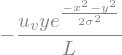

In [4]:
x, y, u_v, h_v, L, sigma, H = symbols('x, y, u_v, h_v, L, sigma, H')
U = -u_v*(y/L)*exp(-(x**2 + y**2)/(2*sigma**2))
U

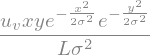

In [5]:
diff(U, x).factor()

In [6]:
def dUx(x, y):
    """ As before """
    r2 = x**2 + y**2
    return uv*x*y/Lv*np.exp(-0.5*r2/s2)/s2

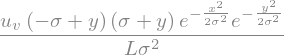

In [7]:
diff(U, y).factor()

In [8]:
def dUy(x, y):
    """ As before """
    r2 = x**2 + y**2
    return uv*(y**2 - s2)/Lv*np.exp(-0.5*r2/s2)/s2

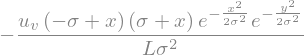

In [9]:
V = u_v*(x/L)*exp(-(x**2 + y**2)/(2*sigma**2))
diff(V, x).factor()

In [10]:
def dVx(x, y):
    """ As before """
    r2 = x**2 + y**2
    return -uv*(x**2 - s2)/Lv*np.exp(-0.5*r2/s2)/s2

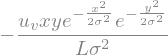

In [11]:
diff(V, y).factor()

In [12]:
def dVy(x, y):
    """ As before """
    r2 = x**2 + y**2
    return uv*x*y/Lv*np.exp(-0.5*r2/s2)/s2

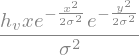

In [13]:
h = H - h_v*exp(-(x**2+y**2)/(2*sigma**2))
diff(h, x).factor()

In [14]:
def dHx(x, y):
    """ Idem """
    r2 = x**2 + y**2
    return hv*x*np.exp(-0.5*r2/s2)/s2


def dHy(x, y):
    """ Idem """
    r2 = x**2 + y**2
    return hv*y*np.exp(-0.5*r2/s2)/s2

## The ray tracing equations

Recall the local or absolute frequency
$$\omega_{abs} = \omega_{int} + \boldsymbol{k\cdot U}, \quad\text{where}\quad \omega_{int} = \sqrt{f^2 + gh(\boldsymbol r)\kappa^2}$$
is the intrinsic frequency, and where $\kappa = |\boldsymbol k| = \sqrt{k_x^2 + k_y^2}$ .

### The positions are solutions to
$$\frac{d \boldsymbol r}{dt} = \boldsymbol{\nabla}_{\boldsymbol k}\omega_a = \boldsymbol c_{g} + \boldsymbol U,$$
where the local or absolute group velocity is (see SymPy cell below)
$$\boldsymbol c_{g} = \boldsymbol{\nabla}_{\boldsymbol k}\omega_i = \frac{g h(\boldsymbol r)}{\omega_{int}}\boldsymbol k.$$

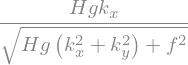

In [15]:
f, g, H, k_x, k_y = symbols('f, g, H, k_x, k_y')
diff(sqrt(f**2 + g*H*(k_x**2 + k_y**2)), k_x)

### The wavevectors are solution to

$$\frac{d\boldsymbol k}{dt} = -\boldsymbol{\nabla}\omega_{abs} = -\frac{\partial \omega_{int}}{\partial h}\boldsymbol{\nabla}h -(\boldsymbol{\nabla U})\cdot\boldsymbol k = -\frac{g \kappa^2}{2\omega_{int}}\boldsymbol{\nabla}h - k_i\boldsymbol{\nabla}U_i.$$

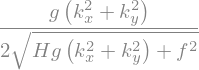

In [16]:
diff(sqrt(f**2 + g*H*(k_x**2 + k_y**2)), H)

### Summary

$$
\begin{align*}
    \frac{dx}{dt} & = \frac{g h(\boldsymbol r)}{\omega_{int}(\boldsymbol{r}, \kappa)} k_x + U, \\
    \frac{dy}{dt} & = \frac{g h(\boldsymbol r)}{\omega_{int}(\boldsymbol{r}, \kappa)} k_y + V, \\
    \frac{dk_x}{dt} & = -\frac{g k^2}{2\omega_{int}(\boldsymbol{r}, \kappa)}\frac{\partial h}{\partial x} - k_x\frac{\partial U}{\partial x} - k_y\frac{\partial V}{\partial x} \quad\text{and}\quad\\
    \frac{dk_y}{dt} & = -\frac{g k^2}{2\omega_{int}(\boldsymbol{r}, \kappa)}\frac{\partial h}{\partial y} - k_x\frac{\partial U}{\partial y} - k_y\frac{\partial V}{\partial y}.
\end{align*}
$$

The idea is to solve this as a set of coupled ODEs with one of the `scipy.integrate` [routines](https://docs.scipy.org/doc/scipy/reference/integrate.html#solving-initial-value-problems-for-ode-systems).

## The code

In [17]:
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

In [18]:
def wint(x, y, kap2):
    return (fcor**2 + grav*Height(x, y)*kap2)**.5

def rhs(t, r):
    """ r: [x, y, kx, ky] """
    k2 = r[2]**2 + r[3]**2
    c02 = grav*Height(r[0], r[1])
    oint = wint(r[0], r[1], k2)
    RHSs = [Uvel(r[0], r[1]) + c02*r[2]/oint,
            Vvel(r[0], r[1]) + c02*r[3]/oint, 
            -.5*grav*k2*dHx(r[0], r[1])/oint - r[2]*dUx(r[0], r[1]) - r[3]*dVx(r[0], r[1]),
            -.5*grav*k2*dHy(r[0], r[1])/oint - r[2]*dUy(r[0], r[1]) - r[3]*dVy(r[0], r[1])]
    return RHSs

In [30]:
Ro = .1  # []
fcor = 1e-4  # rad/s
grav = 9.81  # m/s2
dt = 312.2529  # s (not sure why for now)
Lv = 25000.  # vortex scale
Hm = 0.6371  # background depth

c02 = grav*Hm
hv = Ro*(Lv*fcor)**2/grav
s2 = (Lv/pi)**2  # simga squared (I don't think we ever need sigma itself)
uv = Ro*pi**2*fcor*Lv

bigK = 4.  # Kap = L/lambda_x = L*kx/(2*pi)
kx0 = 2*pi*bigK/Lv
x0 = -4*Lv

oref = (fcor**2 + c02*kx0**2)**.5  # frequency w/o vortex
cgref = c02*kx0/oref  # group speed w/o vortex
Ttransit = 2*abs(x0)/cgref  # time it takes to go through domain
t_array = np.arange(0., Ttransit, dt)

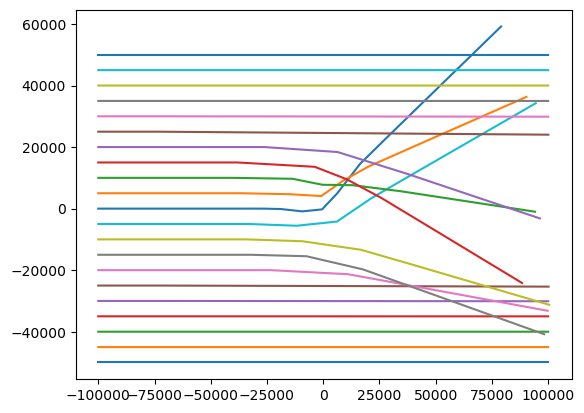

In [32]:
for y0 in np.linspace(-2*Lv, 2*Lv, 21):
    r0 = [x0, y0, kx0, 0.]
    ray = solve_ivp(lambda t, y: rhs(t, y), t_span=[0., Ttransit], y0=r0) #, t_eval=t_array)

    plt.plot(ray.y[0], ray.y[1])

Note that we find the bottom-top-bottom deviation pattern when $Ro$ is big enough (0.1 in the case I'm plotting), but only top when the Rossby is small (try 0.01).

**I would like to plot each term on the RHS of the $dk_y/dt$ equation to see what's causing the top/down deviations. A scatter plot, colour-coded with the value of each term should be enough.**

## Tracking the amplitude

This relies on the conservation of action $\mathcal A = \bar E/\omega_{int}$, where "$\bar E$ is the phase-averaged density of disturbance energy" (Bühler 2014, §4.4.4). What matters here is that $\bar E \propto A_w^2$, where $A_w$ is the wave perturbation amplitude we are looking for. The conservation law reads
$$\frac{d\mathcal A}{dt} = - \mathcal A \boldsymbol{\nabla\cdot} (\boldsymbol c_g + \boldsymbol U) \quad\Leftrightarrow\quad \frac{d(\ln \mathcal A)}{dt} = - \boldsymbol{\nabla\cdot} (\boldsymbol c_g + \boldsymbol U),$$
where we recall that $\boldsymbol c_{g} = g h\boldsymbol k/\omega_{int}$.
*Careful: $\boldsymbol c_g$ in Bühler refers to the **local**, i.e., **absolute**, group velocity. For us, $\boldsymbol c_g$ is the **intrinsic** group velocity, which is why we need to add $\boldsymbol U$ to $\boldsymbol c_g$ in Bühler's Eq. (4.110).*

So, we just have to add a "passive tracer" equation to the set of five equations for the evolution of $\mathcal A$.

Unpacking the group velocity divergence,
$$\boldsymbol{\nabla\cdot}\left(\frac{h(\boldsymbol r)}{\omega_{int}}\boldsymbol k\right) = \frac{\partial}{\partial h}\left(\frac{h}{\omega_{int}}\right)\left(\frac{\partial h}{\partial x}k_x + \frac{\partial h}{\partial y}k_y\right)$$

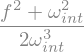

In [22]:
kappa, omega_int = symbols('kappa, omega_int', positive=True)
diff(H/sqrt(f**2 + g*H*kappa**2), H).subs(H*g*kappa**2, omega_int**2 - f**2).factor()

And so the final equation for $\mathcal A$ is
$$\frac{d\ln(\mathcal A)}{dt} = -g\frac{\omega_{int}^2 + f^2}{2\omega_{int}^3}\left(\frac{\partial h}{\partial x}k_x + \frac{\partial h}{\partial y}k_y\right) - \frac{\partial U}{\partial x} - \frac{\partial V}{\partial y}.$$

In [23]:
def rhs_A(t, r):
    """ r: [x, y, kx, ky, lnA], with lmA the wave action log """
    k2 = r[2]**2 + r[3]**2
    c02 = grav*Height(r[0], r[1])
    oint = wint(r[0], r[1], k2)
    prefac_mcA = -.5*grav*(oint**2 + fcor**2)*oint**(-3)
    RHSs = [Uvel(r[0], r[1]) + c02*r[2]/oint,
            Vvel(r[0], r[1]) + c02*r[3]/oint, 
            -.5*grav*k2*dHx(r[0], r[1])/oint - r[2]*dUx(r[0], r[1]) - r[3]*dVx(r[0], r[1]),
            -.5*grav*k2*dHy(r[0], r[1])/oint - r[2]*dUy(r[0], r[1]) - r[3]*dVy(r[0], r[1]),
            prefac_mcA*(dHx(r[0], r[1])*r[2] + dHy(r[0], r[1])*r[3]) - dUx(r[0], r[1]) - dVy(r[0], r[1])]
    return RHSs

I will artificially decrease the speed of the algorithm by using the `t_eval=t_array` option. Two advantages:
1. All rays will have the same number of points, meaning I can put everyone in a big numpy array.
2. I can do a "global" scatterplot to have the same color scale across all rays.

In [24]:
nrays = 41
nt = len(t_array)
rays = np.empty((5, nrays, nt))
for nray, y0 in enumerate(np.linspace(-2*Lv, 2*Lv, nrays)):
    r0 = [x0, y0, kx0, 0., 1.]
    ray = solve_ivp(lambda t, y: rhs_A(t, y), t_span=[0., Ttransit], y0=r0, 
                        t_eval=t_array)
    rays[:, nray, :] = ray.y

oint_array = wint(rays[0, :, :], rays[1, :, :], rays[2, :, :]**2 + rays[3, :, :]**2)
Aw = (np.exp(rays[4, :, :])*oint_array)**.5  # Wave amplitude

/var/folders/7y/707b3rbx7dv9jch1hz6swz1w0000gn/T/ipykernel_89755/2728913813.py:2: RuntimeWarning: invalid value encountered in double_scalars
  return (fcor**2 + grav*Height(x, y)*kap2)**.5


ValueError: could not broadcast input array from shape (5,251) into shape (5,257)

In [ ]:
angles = np.linspace(0, 2*pi, 361)
xin, yin = Lv*np.cos(angles), Lv*np.sin(angles)
xout, yout = 2*Lv*np.cos(angles), 2*Lv*np.sin(angles)

fg, ax = plt.subplots(1, 1, dpi=150)
ax.plot(xin/Lv, yin/Lv, 'g', linewidth=1, alpha=0.5)
ax.plot(xout/Lv, yout/Lv, 'g--', linewidth=1, alpha=0.5)
cb = plt.scatter(rays[0, :, :]/Lv, rays[1, :, :]/Lv, s=4, c=Aw, cmap='plasma', alpha=.5)
ax.set_xlabel('$x/L$')
ax.set_ylabel('$y/L$')
ax.set_title("Rays, colour-coded by amplitude")
ax.set_aspect('equal')
plt.colorbar(ax=ax, orientation='horizontal')

Note: I am not super fan of the one that goes straight through the middle.

## With Jeff's vortex

What preceded was a toy model. Indeed, I needed something quick because for what comes next, I will need to interpolate the mean flow values, and it takes quite a bit of time. Nevertheless, this section should be the definitive one, or meant to become it.

It was simpler to create a new notebook: see `sw-actual.ipynb`.